In [1]:
from collections import defaultdict
from os.path import commonprefix
from Bio import SeqIO
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from scipy import stats

In [2]:
sns.set_style('ticks')
sns.set_context('paper')

# For publication
# mpl.rcParams['axes.titlesize'] = 8
# mpl.rcParams['axes.labelsize'] = 8
# mpl.rcParams['xtick.labelsize'] = 6
# mpl.rcParams['ytick.labelsize'] = 6
# mpl.rcParams['font.size'] = 6

colours = {'DNA': '#fab95b', 
           'LTR': '#665c84', 
           'LINE': '#71a0a5', 
           'RC': '#ED7F35',
           'SINE': '#5E96B5',
           'Other': '#212121'}

### Analysis of transposable element distribution across the zebrfish genome
Transposable elements are non-randomly distributed on and between chromosomes. Most notably, the long arm of chromosome 4 has a strikingly high density of LTR and LINE elements. More generally, we see that specific classes of TEs show distinct, sometimes correlated patterns of genomic distribution.

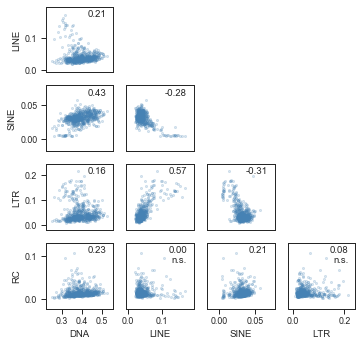

In [3]:
# TODO: Clean this up and don't generate empty plots

# Double counting LTRs? Check this.

df = pd.read_csv('../data/circosfig/gene.density.txt', header=None, sep='\t')
df = df.rename({3: 'gene'}, axis=1)
for i in ['LTR', 'LINE', 'SINE', 'DNA', 'RC', 'BRSATI']:
    df = df.merge(pd.read_csv(f'../data/circosfig/{i}.density.txt', header=None, sep='\t'), 
                  on=[0, 1, 2])
    df = df.rename({3: f'{i}'}, axis=1)
df = df.drop(2, axis=1).rename({0: 'chr', 1: 'window_start'}, axis=1).sort_values('gene')
df = df.loc[df['chr'].isin([str(i) for i in range(1, 26)])]

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(7, 7), sharex=False, sharey=False)
for i, label in enumerate(['DNA', 'LINE', 'SINE', 'LTR', 'RC']):
    j = i
    axes[i][0].set_ylabel(label)
    axes[4][j].set_xlabel(label)
for i, labely in enumerate(['DNA', 'LINE', 'SINE', 'LTR', 'RC']):
    for j, labelx in enumerate(['DNA', 'LINE', 'SINE', 'LTR', 'RC']):
        if i <= j:
            axes[i][j].set_visible(False)
        else:
            r = stats.spearmanr(df[labelx], df[labely])
            axes[i][j].scatter(df[labelx], df[labely], color='steelblue', alpha=0.2, s=5)
            if r.pvalue < 0.001:
                axes[i][j].text(0.9, 0.85, f'{r.correlation:.2f}', transform=axes[i][j].transAxes, horizontalalignment='right')
            else:
                axes[i][j].text(0.9, 0.7, f'{r.correlation:.2f}\nn.s.', transform=axes[i][j].transAxes, horizontalalignment='right')
        if i != 4:
            axes[i][j].set_xticks([])
        if j != 0:
            axes[i][j].set_yticks([])    

fig.savefig('/Users/jonwells/Projects/feschottelab/drerio-tes/figs/ltr_line_corr.pdf', bbox_inches='tight')

In [4]:
def print_corrs(omit_chr4=None):
    """Pretty print tables of TE distribution correlations"""
    for i, val0 in enumerate(['LTR', 'LINE', 'SINE', 'DNA', 'RC', 'BRSATI']):
        for j, val1 in enumerate(['LTR', 'LINE', 'SINE', 'DNA', 'RC', 'BRSATI']):
            if i >= j:
                continue
            if omit_chr4:
                sr = stats.spearmanr(df.loc[df['chr'] != '4', val0],
                                     df.loc[df['chr'] != '4', val1])
            else:
                sr = stats.spearmanr(df[val0], df[val1])
            if sr[1] < 0.001:
                print(f'{val0}\t{val1}\t{sr[0]:.2}\t{sr[1]:.2e}')
            else:
                print(f'{val0}\t{val1}\tns\tns')
    
print('Correlations between TE families')
print_corrs()
print('\nCorrelations between TE families, excluding chr4')
print_corrs(True)

Correlations between TE families
LTR	LINE	0.57	3.92e-60
LTR	SINE	-0.31	1.82e-16
LTR	DNA	0.16	1.57e-05
LTR	RC	ns	ns
LTR	BRSATI	0.22	3.06e-09
LINE	SINE	-0.28	1.65e-13
LINE	DNA	0.21	1.34e-08
LINE	RC	ns	ns
LINE	BRSATI	0.2	7.21e-08
SINE	DNA	0.43	1.11e-32
SINE	RC	0.21	1.56e-08
SINE	BRSATI	-0.15	6.15e-05
DNA	RC	0.23	1.94e-09
DNA	BRSATI	ns	ns
RC	BRSATI	ns	ns

Correlations between TE families, excluding chr4
LTR	LINE	0.51	4.27e-44
LTR	SINE	-0.26	3.07e-11
LTR	DNA	0.24	9.77e-10
LTR	RC	ns	ns
LTR	BRSATI	0.24	1.36e-09
LINE	SINE	-0.21	4.94e-08
LINE	DNA	0.31	2.35e-16
LINE	RC	ns	ns
LINE	BRSATI	0.22	1.22e-08
SINE	DNA	0.36	8.12e-22
SINE	RC	0.2	1.66e-07
SINE	BRSATI	-0.18	5.01e-06
DNA	RC	0.2	1.98e-07
DNA	BRSATI	ns	ns
RC	BRSATI	ns	ns


#### Calculate expected intragenic distributions
Overall we find that DNA transposons are preferentially intragenic compared to LINE and LTR elements. These are significantly different from expected based on random shuffling.

In [5]:
def parse_bed(filename, intragenic=False, extype=None, exnum=None):
    """This function parses bed files returned from `bedtools closest`"""
    chroms = [f'chr{i}' for i in range(1,26)]
    
    bed_df = pd.read_csv(filename, 
                         sep='\t',
                         header=None,
                         names=['chrom', 'testart', 'teend', 'tename', 'tefam', 'strand',
                                'chrom2', 'genestart', 'geneend', 'genename', 'dist'],
                         index_col=False)
    bed_df = bed_df[['chrom', 'tename', 'tefam', 'dist']]
    bed_df = bed_df.loc[bed_df['chrom'].isin(chroms)]
    bed_df['teclass'] = bed_df['tefam'].apply(lambda x: x.split('/')[0])
    bed_df['tefam'] = bed_df['tefam'].apply(lambda x: x.split('/')[-1])
    bed_df.loc[bed_df['tefam'] == 'RC', 'teclass'] = 'RC'
    # Calculate median distance for each tename
    bed_df = bed_df \
        .groupby(['tename', 'teclass']) \
        .median() \
        .reset_index()

    # Calculate intragenic fraction
    if intragenic:
        bed_df['intragenic'] = bed_df['dist'].apply(lambda x: int(bool(x == 0)))
        bed_df = bed_df \
            .groupby('teclass') \
            .agg({'intragenic': ['count', 'sum']}) \
            .reset_index()
        bed_df.columns = ['teclass', 'total', 'intragenic']
        bed_df['frac'] = bed_df['intragenic']/bed_df['total']
        bed_df['experiment_type'] = extype
        bed_df['experiment_num'] = exnum
    return bed_df

In [6]:
dist_df = parse_bed('../data/dist/GRCz11_defrag_te_closest_gene.bed')
print(dist_df)

              tename teclass    dist
0           ACROBAT1     DNA     0.0
1           ACROBAT2     DNA     0.0
2              ANGEL     DNA     0.0
3        Academ-1_DR     DNA     0.0
4      Academ-N1_DRe     DNA     0.0
...              ...     ...     ...
1803  piggyBac-N5_DR     DNA     0.0
1804  piggyBac-N6_DR     DNA  6282.0
1805  piggyBac-N7_DR     DNA     0.0
1806  piggyBac-N8_DR     DNA     0.0
1807  piggyBac-N9_DR     DNA     0.0

[1808 rows x 3 columns]


In [7]:
# Double check before running - this takes a while

# dflist = [parse_bed('../data/shuffled-beds/te_gene_observed.bed',
#                    intragenic=True, 
#                    extype='obs', 
#                    exnum=0)]
# for i, filename in enumerate(os.listdir('../data/shuffled-beds/')):
#     if filename == 'te_gene_observed.bed':
#         continue
#     dflist.append(parse_bed(f'../data/shuffled-beds/{filename}', 
#                             intragenic=True, 
#                             extype='ex', 
#                             exnum=i))
# shuffled_intragenic_df = pd.concat(dflist)

# print(shuffled_intragenic_df)

In [7]:
ss_df = parse_bed('../data/dist/GRCz11_defrag_te_closest_gene_ss.bed')
ds_df = parse_bed('../data/dist/GRCz11_defrag_te_closest_gene_ds.bed')

ss_df['type'] = 'same strand'
ds_df['type'] = 'opposite strand'
stranddist_df = pd.concat([ss_df, ds_df])
print(stranddist_df)

              tename teclass     dist             type
0           ACROBAT1     DNA  19259.0      same strand
1           ACROBAT2     DNA   5653.5      same strand
2              ANGEL     DNA  12528.5      same strand
3        Academ-1_DR     DNA  29085.0      same strand
4      Academ-N1_DRe     DNA   4564.0      same strand
...              ...     ...      ...              ...
1803  piggyBac-N5_DR     DNA  21856.0  opposite strand
1804  piggyBac-N6_DR     DNA  36559.0  opposite strand
1805  piggyBac-N7_DR     DNA  13067.5  opposite strand
1806  piggyBac-N8_DR     DNA   6788.0  opposite strand
1807  piggyBac-N9_DR     DNA  25592.0  opposite strand

[3616 rows x 4 columns]


/Users/jonwells/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:6475: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
No handles with labels found to put in legend.


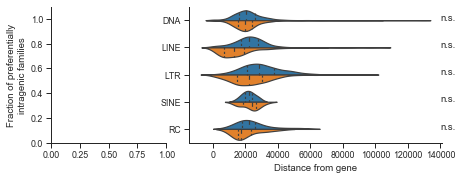

In [8]:
fig = plt.figure(figsize=(7,2.5))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1:])

# sns.barplot(data=shuffled_intragenic_df[shuffled_intragenic_df['teclass'].isin(['LINE', 'RC', 'SINE', 'DNA', 'LTR'])], 
#             x='teclass',
#             y='frac',
#             hue='experiment_type',
#             order=['RC', 'DNA', 'SINE', 'LINE', 'LTR'],
#             ax=ax0,
#             lw=0.6,
#             edgecolor='black')

# # Significance annotations
# for i, teclass in enumerate(['RC', 'DNA', 'SINE', 'LINE', 'LTR']):
#     k = shuffled_intragenic_df.loc[(shuffled_intragenic_df['teclass'] == teclass) &
#                                    (shuffled_intragenic_df['experiment_type'] == 'obs'), 
#                                    'intragenic']
#     n = shuffled_intragenic_df.loc[(shuffled_intragenic_df['teclass'] == teclass) &
#                                    (shuffled_intragenic_df['experiment_type'] == 'obs'), 
#                                    'total']
#     p = shuffled_intragenic_df.loc[(shuffled_intragenic_df['teclass'] == teclass) &
#                                    (shuffled_intragenic_df['experiment_type'] == 'ex')].mean()['frac']
#     pval = stats.binom.pmf(k, n, p)
#     if pval[0] <= 0.01:
#         ax0.text(i, 1.08, f'{pval[0]:.0e}', horizontalalignment='center')
#     else:
#         ax0.text(i, 1.08, 'n.s.', horizontalalignment='center')
sns.violinplot(data=stranddist_df.loc[stranddist_df['teclass'].isin(['DNA', 'LINE', 'LTR', 'SINE', 'RC'])], 
              y='teclass', 
              x='dist', 
              hue='type',
              order=['DNA', 'LINE', 'LTR', 'SINE', 'RC'],
              split=True,
              inner='quartile',
              alpha=0.2,
              ax=ax1)

# Significance annotations
for i, teclass in enumerate(['DNA', 'LINE', 'LTR', 'SINE', 'RC']):
    wrs = stats.ranksums(stranddist_df.loc[(stranddist_df['teclass'] == teclass) & (stranddist_df['type'] == 'same_strand')]['dist'],
                         stranddist_df.loc[(stranddist_df['teclass'] == teclass) & (stranddist_df['type'] == 'diff_strand')]['dist'])
    if wrs[1] <= 0.01:
        ax1.text(140000, i, f'{wrs[1]:.0e}')
    else:
        ax1.text(140000, i, 'n.s.')

ax0.set_ylim(0, 1.1)
ax0.set_xlabel('')
ax1.set_xlabel('Distance from gene')
ax0.set_ylabel('Fraction of preferentially\nintragenic families')
ax1.set_ylabel('')
ax0.legend().remove()
ax1.legend().remove()

sns.despine()
plt.show()
fig.savefig('/Users/jonwells/Projects/feschottelab/drerio-tes/figs/genomic_dist.pdf', bbox_inches='tight')

In [30]:
def parse_tss_bed(filename, intragenic=False, extype=None, exnum=None):
    """This function parses bed files returned from `bedtools closest`"""
    chroms = [f'chr{i}' for i in range(1,26)]
    
    bed_df = pd.read_csv(filename, 
                         sep='\t',
                         header=None,
                         names=['chrom', 'testart', 'teend', 'tename', 'tefam', 'strand',
                                'chrom2', 'genestart', 'geneend', 'genename', 'dist'],
                         index_col=False)
    bed_df = bed_df[['chrom', 'tename', 'tefam', 'dist']]
    bed_df = bed_df.loc[bed_df['chrom'].isin(chroms)]
    bed_df['teclass'] = bed_df['tefam'].apply(lambda x: x.split('/')[0])
    bed_df['tefam'] = bed_df['tefam'].apply(lambda x: x.split('/')[-1])
    bed_df.loc[bed_df['tefam'] == 'RC', 'teclass'] = 'RC'
    # Calculate median distance for each tename
    bed_df = bed_df \
        .groupby(['tename', 'teclass']) \
        .median() \
        .reset_index()

    return bed_df

In [91]:
chroms = [f'chr{i}' for i in range(1,26)]
ss_df = pd.read_csv('../data/dist/GRCz11_defrag_te_closest_gene_ss_signed.bed', 
                         sep='\t',
                         header=None,
                         names=['chrom', 'testart', 'teend', 'tename', 'tefam', 'strand',
                                'chrom2', 'genestart', 'geneend', 'genename', 'dist'],
                         index_col=False)
ss_df = ss_df.loc[ss_df.chrom.isin(chroms)]
ss_df['teclass'] = ss_df['tefam'].apply(lambda x: x.split('/')[0])
ss_df['tefam'] = ss_df['tefam'].apply(lambda x: x.split('/')[-1])
ss_df.loc[ss_df['tefam'] == 'RC', 'teclass'] = 'RC'


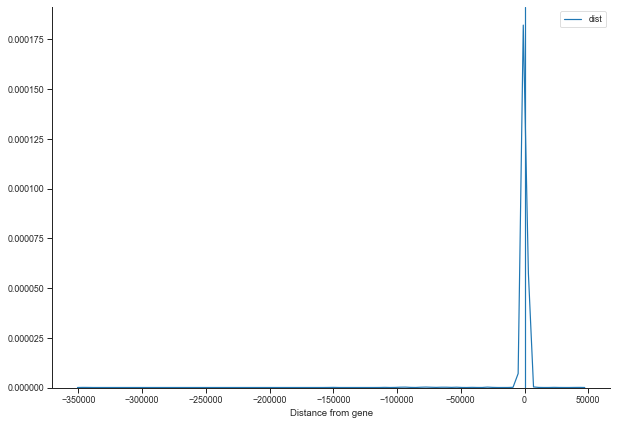

In [112]:
fig, ax = plt.subplots(figsize=(10, 7))

# sns.kdeplot(data=ss_df.loc[ss_df['teclass'].isin(['DNA', 'LINE', 'LTR', 'SINE', 'RC'])], 
#               y='teclass', 
#               x='dist', 
#               order=['DNA', 'LINE', 'LTR', 'SINE', 'RC'],
#               ax=ax)
ax.axvline(x=0)
# sns.kdeplot(ss_df.loc[ss_df.tename == 'ANGEL']['dist'])
# sns.kdeplot(ss_df.loc[ss_df.tename == 'Gypsy5']['dist'])
sns.kdeplot(ss_df.loc[ss_df.tename == 'L1-2_DR']['dist'])
# sns.scatterplot(ss_df.loc[ss_df.tename == 'L1-2_DR']['dist'])

# sns.kdeplot(ss_df.loc[ss_df.teclass == 'DNA']['dist'])
# sns.kdeplot(ss_df.loc[ss_df.teclass == 'LINE']['dist'])
# sns.kdeplot(ss_df.loc[ss_df.teclass == 'SINE']['dist'])

# Significance annotations
# for i, teclass in enumerate(['DNA', 'LINE', 'LTR', 'SINE', 'RC']):
#     wrs = stats.ranksums(stranddist_df.loc[(stranddist_df['teclass'] == teclass) & (stranddist_df['type'] == 'same_strand')]['dist'],
#                          stranddist_df.loc[(stranddist_df['teclass'] == teclass) & (stranddist_df['type'] == 'diff_strand')]['dist'])
#     if wrs[1] <= 0.01:
#         ax1.text(140000, i, f'{wrs[1]:.0e}')
#     else:
#         ax1.text(140000, i, 'n.s.')

ax.set_xlabel('Distance from gene')
# ax.set_xlim((-5000, 5000))
# ax.set_yscale('log')

sns.despine()
plt.show()
